# US Department of Education College Scorecard Data Analysis

#### It is well known that having a college degree of some kind increases your earning potential for the rest of your life by a significant amount. But, are higher tuition costs possibly justified because they're correlated with higher post-graduate earnings? How is the admissions rate of a college related to graduates' earning potential? To answer these questions, and more, we turn to the US Department of Education's College Scorecard Data.

First, let's import data and necessary packages.

In [18]:
import pandas as pd
import numpy as np
import thinkplot
%matplotlib inline

#load 2012-13 and 2014-15 College Scorecard data
cs2012_13 = pd.read_csv('CollegeScorecard_Raw_Data/MERGED2012_13_PP.csv')
cs2014_15 = pd.read_csv('CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv')

col_name=cs2012_13.columns[0]
cs2012_13 = cs2012_13.rename(columns = {col_name:'UNITID'})
col_name=cs2014_15.columns[0]
cs2014_15 = cs2014_15.rename(columns = {col_name:'UNITID'})

print(len(cs2012_13.index))
print(len(cs2014_15.index))

/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1537,1540,1542,1575,1606,1614,1615,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,9,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1411,1425,1427,1503,1517,1529,1530,1532,1537,1540,1541,1542,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1605,1606,1609,1610,1613,1614,1615,1725,1726,1727,1728,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


7793
7703


If we're looking at answering some of these questions as a way to help people make choices between colleges, then we should first filter out institutions that are no longer operating. 

Because the 2012-13 dataset contains the mean earnings after graduation data that we're interested in but no data on whether or not schools are operating, we need to match the operating data from the 2014-15 dataset to schools in the 2012-13 dataset.

In [11]:
#loops through schools in the 2014-15 dataset by row index
for i in range(len(cs2014_15.CURROPER)):
    #ensures that the school OPEID exists before using as a reference for data
    if not cs2012_13[cs2012_13['OPEID'] == cs2014_15.OPEID.iloc[i]].empty:
        cs2012_13.set_value(cs2012_13[cs2012_13['OPEID'] == cs2014_15.OPEID.iloc[i]].index[0], "CURROPER", cs2014_15.CURROPER.iloc[i])
    #ensures that the school OPEID6 exists before using as a reference for data
    elif not cs2012_13[cs2012_13['OPEID6'] == cs2014_15.OPEID6.iloc[i]].empty:
        cs2012_13.set_value(cs2012_13[cs2012_13['OPEID6'] == cs2014_15.OPEID6.iloc[i]].index[0], "CURROPER", cs2014_15.CURROPER.iloc[i])
    #ensures that the school UNITID exists before using as a reference for data
    elif not cs2012_13[cs2012_13['UNITID'] == cs2014_15.UNITID.iloc[i]].empty:
        cs2012_13.set_value(cs2012_13[cs2012_13['UNITID'] == cs2014_15.UNITID.iloc[i]].index[0], "CURROPER", cs2014_15.CURROPER.iloc[i])
    #if a school exists in the 2012-13 dataset that doesn't exist in the 2014-15 dataset, it just won't get currently operating data
    #due to the way that we sort for schools that are operating, schools without data are assumed to be no longer operating
        
operating = cs2012_13[cs2012_13.CURROPER == 1]
print(len(operating.index))

6437


After filtering for operating institutions, we go from a total list of 7794 institutions to 6438.

Because what degree you get from college will significantly impact your earning potential (e.g. a person with a PhD is going to be paid more than someone with a bachelor's degree), we're going to focus on institutions that mainly award bachelor's degrees. Let's select for those institutions.

In [12]:
#select operating institutions that mainly award bachelor's degrees
bachelors = operating[operating.PREDDEG == 3]
print(len(bachelors.index))

1990


After selecting for institutions that primarily award bachelor's degrees, we're down to 1991 colleges. This cuts out a significant number of institutions from our dataset, so we'll revisit adding in colleges that predominants award associate's degrees later, especially because a lot of institutions that fall into that category, like community colleges, are a common option for college.

Now, we need to consolidate some of the cost data for institutions. The differences between institutions that use an academic year based calendar system and program-based or continuous enrollment calendar systems does not mean much to us, especially when the College Scorecard annualizes cost data for program-based or continuous enrollment calendar system institutions. Because the Scorecard separates out average annual cost of attendance for academic year institutions and program year institutions, we need to combine the data into a single DataFrame column.

In [15]:
for i in range(len(bachelors.COSTT4_A)):
    if np.isnan(bachelors.COSTT4_A.iloc[i]) == False and np.isnan(bachelors.COSTT4_P.iloc[i]) == True:
        bachelors.loc[i, "COST_COMBO"] = bachelors.COSTT4_A.iloc[i]
    if np.isnan(bachelors.COSTT4_A.iloc[i]) == True and np.isnan(bachelors.COSTT4_P.iloc[i]) == False:
        bachelors.loc[i, "COST_COMBO"] = bachelors.COSTT4_P.iloc[i]
    if np.isnan(bachelors.COSTT4_A.iloc[i]) == False and np.isnan(bachelors.COSTT4_P.iloc[i]) == False:
        print("BOTH VALUES EXIST") #makes sure there is no institution with both COSTT4_A and COSTT4_P data

bachelors = bachelors[pd.notnull(bachelors['COST_COMBO'])]
print(len(bachelors.index))

1909


Because not all schools in the dataset have cost data, we're now down to 1910 colleges. 

In [16]:
#removes schools without earnings data
bachelors = bachelors[pd.notnull(bachelors['MN_EARN_WNE_P10'])]
#removes schools whose earnings data does not meet NSLDS and Treasury reporting standards
bachelors = bachelors[bachelors.MN_EARN_WNE_P10 != 'PrivacySuppressed']

print(len(bachelors.index))

677


We're now down to 678 colleges. Let's see what the relationship between college cost and mean earnings after 10 years looks like. Specifically, we're looking at the relationship between a school's average cost of attendance and that school's students' mean earnings 10 years after graduation.

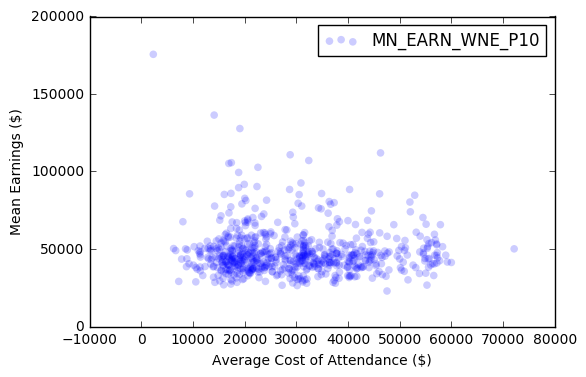

In [21]:
thinkplot.Scatter(bachelors.COST_COMBO, bachelors.MN_EARN_WNE_P10)
thinkplot.Show(xlabel='Average Cost of Attendance ($)',
               ylabel='Mean Earnings ($)')